# The MovieLens Dataset

## Getting the Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2022-02-07 15:01:30--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.08MB/s    in 0.3s    

2022-02-07 15:01:31 (3.08 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
# !unzip ml-latest-small.zip -d /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization

Archive:  ml-latest-small.zip
   creating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/
  inflating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/links.csv  
  inflating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/tags.csv  
  inflating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/ratings.csv  
  inflating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/README.txt  
  inflating: /content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small/movies.csv  


In [3]:
def read_data_ml100k():
    data_dir = '/content/drive/MyDrive/Boostcamp_AI_Tech/Recsys_Implement/Matrix_Factorization/ml-latest-small'
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'ratings.csv'), names = names, header=0)
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

## Statistics of the Dataset

In [4]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 610, number of items: 9724
matrix sparsity: 0.983000
   user_id  item_id  rating  timestamp
0        1        1     4.0  964982703
1        1        3     4.0  964981247
2        1        6     4.0  964982224
3        1       47     5.0  964983815
4        1       50     5.0  964982931


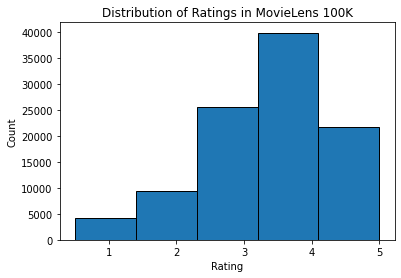

In [5]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

## Label Encoding

In [6]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user_id'].values)
data['item_id_idx'] = item_le.fit_transform(data['item_id'].values)

## Mu

In [7]:
mu = torch.tensor(data['rating'].mean())

## Loading the data

In [8]:
class MovieLensDataset(Dataset):
    def __init__(self, df, train_size=0.9, train=False):
        self.df = df
        self.train = train
        self.train_size = train_size
        self.test_size = 1 - self.train_size 


        self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)

        if self.train == True:
            self.df = self.train_df
        else:
            self.df = self.test_df

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        users = self.users[index]
        items = self.items[index]
        ratings = self.ratings[index]
        return (users, items, ratings.float())

# The Matrix Factorization Model

In [9]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.mu = mu

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        mu = self.mu
        
        outputs = torch.sum((P_u * Q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu
        return outputs.flatten()

## Training and Evaluating the Model

In [10]:
def trainer(model, train_iter, loss, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for i, (users, items, ratings) in enumerate(train_iter):
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)      

        preds = model(users, items)
        loss_out = loss(preds, ratings)

        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [11]:
def evaluator(model, test_iter, device):
    with torch.no_grad():
        model.eval()
        loss = nn.MSELoss()
        loss_sum = 0

        for idx, (users, items, ratings) in enumerate(test_iter):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            preds = model(users, items)

            loss_out = loss(preds, ratings)            

            loss_sum += loss_out.item()

        loss_avg = loss_sum / len(test_iter)

    return loss_avg

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 30
lr = 0.005
mf_factor = 100
batch_size = 128

num_users = data.user_id_idx.max() + 1
num_items = data.item_id_idx.max() + 1

In [13]:
train_dataset = MovieLensDataset(df=data, train=True)
test_dataset = MovieLensDataset(df=data, train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model = MF(mf_factor, num_users, num_items, mu).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 76.0295, test Loss: 55.7922
epoch: 1, train Loss: 24.2877, test Loss: 39.8450
epoch: 2, train Loss: 9.6952, test Loss: 32.0878
epoch: 3, train Loss: 4.5569, test Loss: 27.5831
epoch: 4, train Loss: 2.5318, test Loss: 24.7920
epoch: 5, train Loss: 1.7624, test Loss: 22.5980
epoch: 6, train Loss: 1.6342, test Loss: 21.0972
epoch: 7, train Loss: 1.8609, test Loss: 19.2455
epoch: 8, train Loss: 2.1211, test Loss: 17.7290
epoch: 9, train Loss: 2.0958, test Loss: 16.0052
epoch: 10, train Loss: 1.7766, test Loss: 14.7791
epoch: 11, train Loss: 1.4978, test Loss: 13.6105
epoch: 12, train Loss: 1.4066, test Loss: 12.7365
epoch: 13, train Loss: 1.4299, test Loss: 11.7194
epoch: 14, train Loss: 1.4636, test Loss: 10.9326
epoch: 15, train Loss: 1.3931, test Loss: 9.9948
epoch: 16, train Loss: 1.2627, test Loss: 9.3661
epoch: 17, train Loss: 1.1625, test Loss: 8.6625
epoch: 18, train Loss: 1.1151, test Loss: 8.1070
epoch: 19, train Loss: 1.0927, test Loss: 7.5240
epoch: 20, tr

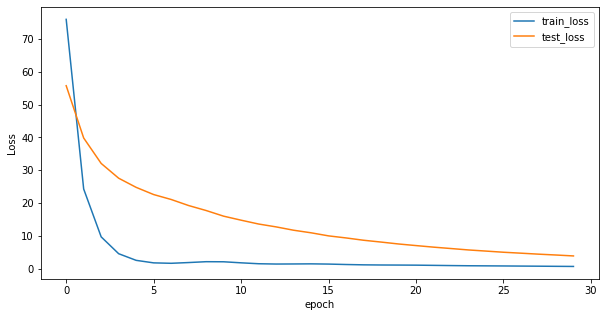

In [15]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    train_loss = trainer(model, train_dataloader, loss, optm, device)
    test_loss = evaluator(model, test_dataloader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(test_losses,label="test_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()